In [56]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [20]:
X = iris.data[:, 2:]
y = iris.target

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (150, 2)
y.shape: (150,)


In [21]:
m = len(X)
X_with_bias = np.c_[np.ones(m), X]
X_with_bias[0]

array([1. , 1.4, 0.2])

In [33]:
def train_valid_test_split(X, y, valid_ratio=0.2, test_ratio=0.2, random_seed=42):
    m = len(X)
    
    test_size = int(m * test_ratio)
    valid_size = int(m * valid_ratio)
    train_size = m - valid_size - test_size

    np.random.seed(random_seed)
    rnd_indices = np.random.permutation(m)

    X_train = X_with_bias[rnd_indices[:train_size]]
    y_train = y[rnd_indices[:train_size]]
    X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
    y_valid = y[rnd_indices[train_size:-test_size]]
    X_test = X_with_bias[rnd_indices[-test_size:]]
    y_test = y[rnd_indices[-test_size:]]

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [34]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X_with_bias, y)

In [35]:
def to_one_hot(y):
    n_classes = y.max() + 1
    return np.diag(np.ones(n_classes))[y]

In [36]:
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_valid)
y_test_one_hot = to_one_hot(y_test)

In [37]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)

X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

In [42]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

In [43]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))

In [48]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    y_proba = softmax(logits)
    if epoch % 1000 == 0:
        y_proba_valid = softmax(X_valid @ Theta)
        entropy_losses = -(y_valid_one_hot * np.log(y_proba_valid + epsilon))
        print(f"Epoch: {epoch} - \t Entropy Loss: {entropy_losses.sum(axis=1).mean()}")
    error = y_proba - y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

Epoch: 0 - 	 Entropy Loss: 3.7085808486476917
Epoch: 1000 - 	 Entropy Loss: 0.14519367480830647
Epoch: 2000 - 	 Entropy Loss: 0.13013095755040874
Epoch: 3000 - 	 Entropy Loss: 0.12009639326384533
Epoch: 4000 - 	 Entropy Loss: 0.11372961364786881
Epoch: 5000 - 	 Entropy Loss: 0.11002459532472421


In [49]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

In [50]:
logits = X_valid @ Theta
y_proba = softmax(logits)
y_pred = y_proba.argmax(axis=1)

accuracy_score = (y_pred == y_valid).mean()
accuracy_score

0.9333333333333333

In [52]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    y_proba = softmax(logits)
    if epoch % 1000 == 0:
        y_proba_valid = softmax(X_valid @ Theta)
        entropy_losses = -(y_valid_one_hot * np.log(y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = entropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(f"Epoch: {epoch} - \t Total Loss: {total_loss.round(4)}")
    error = y_proba - y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

Epoch: 0 - 	 Total Loss: 3.7372
Epoch: 1000 - 	 Total Loss: 0.3259
Epoch: 2000 - 	 Total Loss: 0.3259
Epoch: 3000 - 	 Total Loss: 0.3259
Epoch: 4000 - 	 Total Loss: 0.3259
Epoch: 5000 - 	 Total Loss: 0.3259


In [53]:
logits = X_valid @ Theta
y_proba = softmax(logits)
y_pred = y_proba.argmax(axis=1)

accuracy_score = (y_pred == y_valid).mean()
accuracy_score

0.9333333333333333

In [54]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
C = 100
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    y_proba = softmax(logits)
    y_proba_valid = softmax(X_valid @ Theta)
    entropy_losses = -(y_valid_one_hot * np.log(y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = entropy_losses.sum(axis=1).mean() + alpha * l2_loss
    
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} - \t Total Loss: {total_loss.round(4)}")

    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(f"Epoch: {epoch - 1} - \t Best Loss: {best_loss.round(4)}")
        print(f"Epoch: {epoch} - \t Total Loss: {total_loss.round(4)} - Early Stopping!")
        break
    
    error = y_proba - y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

Epoch: 0 - 	 Total Loss: 3.7372
Epoch: 281 - 	 Best Loss: 0.3256
Epoch: 282 - 	 Total Loss: 0.3256 - Early Stopping!


In [55]:
logits = X_valid @ Theta
y_proba = softmax(logits)
y_pred = y_proba.argmax(axis=1)

accuracy_score = (y_pred == y_valid).mean()
accuracy_score

0.9333333333333333

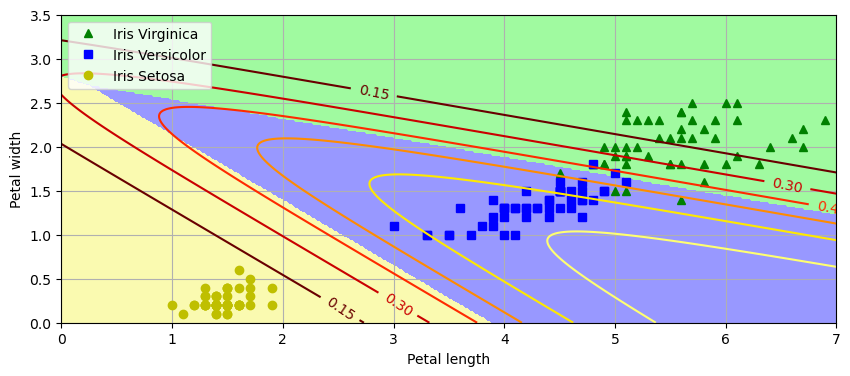

In [57]:
custom_cmap = mpl.colors.ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
y_proba = softmax(logits)
y_pred = y_proba.argmax(axis=1)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_pred.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris Virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris Versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris Setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [58]:
logits = X_test @ Theta
y_proba = softmax(logits)
y_pred = y_proba.argmax(axis=1)

accuracy_score = (y_pred == y_test).mean()
accuracy_score

0.9666666666666667